#  CNN model for the CIFAR-10 dataset

## Dependencies

In [3]:
! pip install torch torchvision matplotlib -q

In [4]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

/Users/mzitoh/anaconda3/envs/class-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [6]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation: Random cropping
    transforms.RandomHorizontalFlip(),    # Data augmentation: Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalization
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalization
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## CNN Model

In [9]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

## Model Training

In [11]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = CIFAR10Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, trainloader, criterion, optimizer, epochs=20, device="cpu"):
    train_losses = []
    train_accuracies = []
    
    start_time = time.time()
    
    print("Training model on {}...".format(device))
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate metrics for the epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    end_time = time.time()
    total_training_time = end_time - start_time
    
    print(f"Total training time: {total_training_time:.2f} seconds")
    
    return train_losses, train_accuracies

In [13]:
def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color="red", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color="blue", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [14]:
train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, epochs=50)

Training model on cpu...
Epoch 1/50, Loss: 1.6900, Accuracy: 37.24%
Epoch 2/50, Loss: 1.2781, Accuracy: 53.84%
Epoch 3/50, Loss: 1.0841, Accuracy: 61.80%
Epoch 4/50, Loss: 0.9765, Accuracy: 65.81%
Epoch 5/50, Loss: 0.9014, Accuracy: 68.77%
Epoch 6/50, Loss: 0.8374, Accuracy: 70.90%
Epoch 7/50, Loss: 0.7870, Accuracy: 72.81%
Epoch 8/50, Loss: 0.7572, Accuracy: 73.90%
Epoch 9/50, Loss: 0.7348, Accuracy: 74.89%
Epoch 10/50, Loss: 0.7085, Accuracy: 75.58%
Epoch 11/50, Loss: 0.6833, Accuracy: 76.52%
Epoch 12/50, Loss: 0.6574, Accuracy: 77.40%
Epoch 13/50, Loss: 0.6473, Accuracy: 77.84%
Epoch 14/50, Loss: 0.6321, Accuracy: 78.32%
Epoch 15/50, Loss: 0.6175, Accuracy: 78.98%
Epoch 16/50, Loss: 0.6105, Accuracy: 79.14%
Epoch 17/50, Loss: 0.6002, Accuracy: 79.44%
Epoch 18/50, Loss: 0.5830, Accuracy: 80.06%
Epoch 19/50, Loss: 0.5684, Accuracy: 80.66%
Epoch 20/50, Loss: 0.5669, Accuracy: 80.61%
Epoch 21/50, Loss: 0.5603, Accuracy: 80.69%
Epoch 22/50, Loss: 0.5491, Accuracy: 81.02%
Epoch 23/50, Los

In [15]:
model_base_path = "../results/model"
os.makedirs(model_base_path, exist_ok=True)

model_save_path = os.path.join(model_base_path, "cifar10_model_weights.pth")

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

Model weights saved to ../results/model/cifar10_model_weights.pth


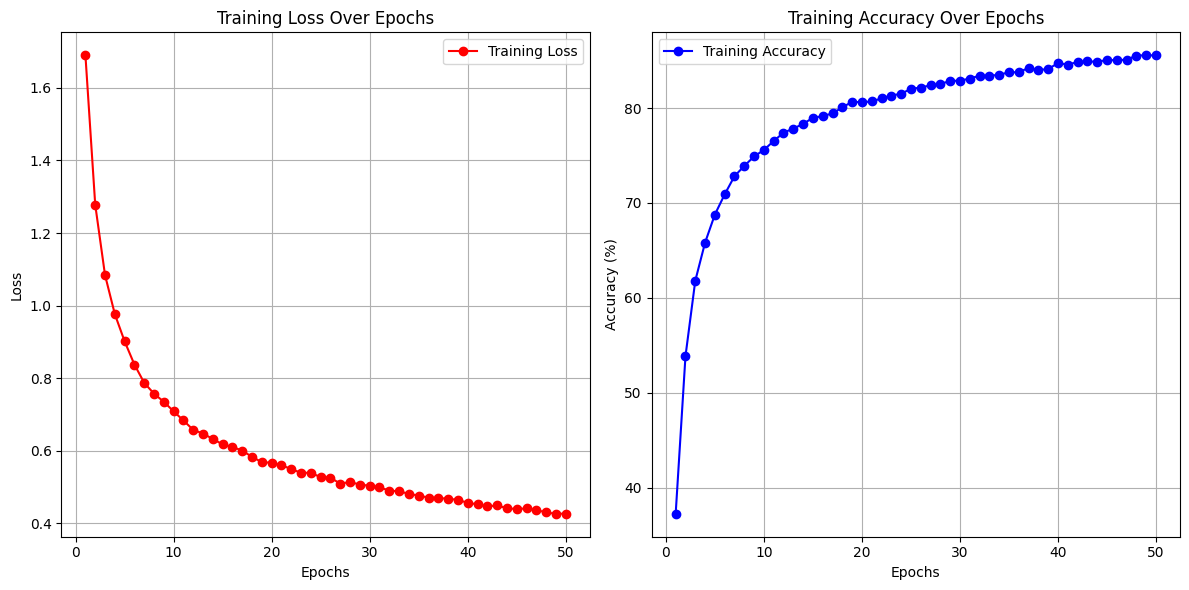

In [16]:
plot_metrics(train_losses, train_accuracies)

## Model Evaluation

In [18]:
def evaluate_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [19]:
def visualize_predictions(model, testloader):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Plot the images
    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = np.clip(images * 0.247 + 0.491, 0, 1)  # De-normalize for visualization

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
        axes[i].axis('off')
    plt.show()


In [20]:
evaluate_model(model, testloader)

Test Accuracy: 84.63%


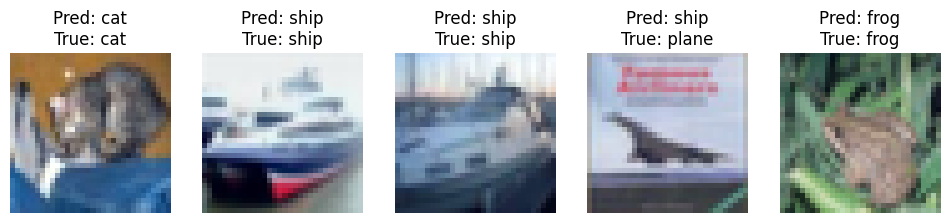

In [21]:
visualize_predictions(model, testloader)